# Autor: Eric Cestari
# Curso: Data Science & Analytics
# Título: Predição de churn em uma empresa de telecomunicações através de modelos de Machine Learning

## Entendimento do estudo

Esse trabalho objetiva explorar os dados relacionados ao churn rate de clientes de uma empresa e entender como estão dispostos, descrevendo quais as possíveis variáveis que podem ou não influenciar a fidelização ou não dos clientes, trabalhar os dados e prepara-los para então desenvolver quatro modelos diferentes de machine learning, definindo qual modelo apresenta a maior acuracidade de predição, se o cliente tem ou não risco de churn, para servir como tomada de decisão para gestores.

## Estrutura
1. Importando os dados
2. Limpeza e pré-processamento dos dados
3. Análise exploratória dos dados
4. Preparação dos dados para modelos de machine learning
5. Divisão dos dados em treino e teste
6. Treinamento dos dados nos modelos de Machine Learning
7. Avaliação de performance dos modelos

## Importando as bibliotecas

In [2]:
# Manipulação dos dados
import pandas as pd
# Para trabalhar com matrizes
import numpy as np
# Gráficos
import seaborn as sns
# Interface gráfica
import matplotlib.pyplot as plt

import mglearn

# Pacotes para preparação dos dados
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import StandardScaler

# criação de modelos
# import statsmodel as sm
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
from sklearn.model_selection import KFold, cross_val_score

# importância de features
from sklearn.feature_selection import RFE

# validação
from sklearn import metrics
from sklearn.tree import export_graphviz
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

import graphviz

# lazy predict
import lazypredict
from lazypredict.Supervised import LazyClassifier

# Filtro de Warning
from warnings import simplefilter

# Ignorar warnings
simplefilter(action='ignore', category=FutureWarning)

# 1. Importando os dados

In [3]:
dados = pd.read_excel('data_churn.xlsx')

## Entendendo os dados

In [4]:
# Verificando a dimensão do DataFrame
print('O DataFrame possui {} observações (linhas) e {} variáveis (colunas).\n'.format(dados.shape[0], dados.shape[1]))

O DataFrame possui 7043 observações (linhas) e 33 variáveis (colunas).



In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Count              7043 non-null   int64  
 2   Country            7043 non-null   object 
 3   State              7043 non-null   object 
 4   City               7043 non-null   object 
 5   Zip Code           7043 non-null   int64  
 6   Lat Long           7043 non-null   object 
 7   Latitude           7043 non-null   float64
 8   Longitude          7043 non-null   float64
 9   Gender             7043 non-null   object 
 10  Senior Citizen     7043 non-null   object 
 11  Partner            7043 non-null   object 
 12  Dependents         7043 non-null   object 
 13  Tenure Months      7043 non-null   int64  
 14  Phone Service      7043 non-null   object 
 15  Multiple Lines     7043 non-null   object 
 16  Internet Service   7043 

In [6]:
# Visualizar as 5 primeiras linhas
dados.head(5)

,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.96,-118.27,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.06,-118.31,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.05,-118.29,Female,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.06,-118.32,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.04,-118.27,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


In [7]:
# Traduzindo o nome das variáveis originais do Inglês para o Português
dados = dados.rename(columns={'CustomerID': 'IDUsuario', 'Count': 'Contagem', 'Country': 'Pais', 'State': 'Estado', 'City': 'Cidade',
                              'Zip Code': 'CodigoPostal', 'Lat Long': 'LatLong', 'Latitude': 'Latitude', 'Longitude': 'Longitude',
                              'Gender': 'Genero', 'Senior Citizen': 'Senior', 'Partner': 'Parceiro', 'Dependents': 'Dependentes',
                              'Tenure Months': 'AssinaturaMeses', 'Phone Service': 'ServicoTelefonia', 'Multiple Lines': 'MultiplasLinhas',
                              'Internet Service': 'ServicoInternet', 'Online Security': 'SegurancaOnline', 'Online Backup': 'BackupOnline',
                              'Device Protection': 'ProtecaoDispositivo', 'Tech Support': 'SuporteTech', 'Streaming TV': 'StreamingTV',
                              'Streaming Movies': 'StreamingFilmes', 'Contract': 'TipoContrato', 'Paperless Billing': 'FaturaSemPapel',
                              'Payment Method': 'MetodoPagamento', 'Monthly Charges': 'CobrancasMensais', 'Total Charges': 'CobrancasTotais',
                              'Churn Label': 'Churn', 'Churn Value': 'ValorChurn', 'Churn Score': 'PontuacaoChurn', 'CLTV': 'CLTV',
                              'Churn Reason': 'MotivoChurn'})

In [8]:
dados.dtypes.value_counts()

object     24
int64       6
float64     3
dtype: int64

In [9]:
dados.describe().round(2)

,Contagem,CodigoPostal,Latitude,Longitude,AssinaturaMeses,CobrancasMensais,ValorChurn,PontuacaoChurn,CLTV
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,1.00,93521.96,36.28,-119.80,32.37,64.76,0.27,58.70,4400.30
std,0.00,1865.79,2.46,2.16,24.56,30.09,0.44,21.53,1183.06
min,1.00,90001.00,32.56,-124.30,0.00,18.25,0.00,5.00,2003.00
25%,1.00,92102.00,34.03,-121.82,9.00,35.50,0.00,40.00,3469.00
50%,1.00,93552.00,36.39,-119.73,29.00,70.35,0.00,61.00,4527.00
75%,1.00,95351.00,38.22,-118.04,55.00,89.85,1.00,75.00,5380.50
max,1.00,96161.00,41.96,-114.19,72.00,118.75,1.00,100.00,6500.00


Inicialmente, observei que existem poucas variáveis quantitativas no conjunto de dados

# 2. Limpeza e pré-processamento dos dados

In [10]:
print('Dados faltantes \n{}.'.format(dados.isnull().sum() / len(dados)))

Dados faltantes 
IDUsuario             0.00
Contagem              0.00
Pais                  0.00
Estado                0.00
Cidade                0.00
CodigoPostal          0.00
LatLong               0.00
Latitude              0.00
Longitude             0.00
Genero                0.00
Senior                0.00
Parceiro              0.00
Dependentes           0.00
AssinaturaMeses       0.00
ServicoTelefonia      0.00
MultiplasLinhas       0.00
ServicoInternet       0.00
SegurancaOnline       0.00
BackupOnline          0.00
ProtecaoDispositivo   0.00
SuporteTech           0.00
StreamingTV           0.00
StreamingFilmes       0.00
TipoContrato          0.00
FaturaSemPapel        0.00
MetodoPagamento       0.00
CobrancasMensais      0.00
CobrancasTotais       0.00
Churn                 0.00
ValorChurn            0.00
PontuacaoChurn        0.00
CLTV                  0.00
MotivoChurn           0.73
dtype: float64.


A variável 'CustomerID' não será importante para o modelo preditivo, uma vez que trata de um número único para cada cliente. Será deletada da base.
Também foi identificado através do resumo que as variáveis 'Count', 'Country' e 'State' possuem apenas um valor único e não são relevantes para a análise. Portanto, irei excluí-las.
Assumimos que o dataset traz informações de clientes dos Estados Unidos, especificamente da Calofornia.

In [11]:
# As variáveis 'CustomerID', 'Count', 'Country', 'State' também não serão utilizadas as variáveis 'Zip Code', 'Lat Long', 'Latitude' e 'Longitude' não agregam valor a análise, portanto serão descartadas
dados.drop(['IDUsuario', 'Contagem', 'Pais', 'Estado', 'CodigoPostal', 'LatLong', 'Latitude', 'Longitude', 'PontuacaoChurn'], inplace=True, axis=1)

In [12]:
# Também será descartada a variável 'Churn Label', pois já temos o mapeamento de churn feito na variável 'Churn Value' sendo 1 para churn e 0 para não churn
#dados.drop(['Churn Label'], inplace=True, axis=1)

In [13]:
# Para mais detalhes do conjunto de dados
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Cidade               7043 non-null   object 
 1   Genero               7043 non-null   object 
 2   Senior               7043 non-null   object 
 3   Parceiro             7043 non-null   object 
 4   Dependentes          7043 non-null   object 
 5   AssinaturaMeses      7043 non-null   int64  
 6   ServicoTelefonia     7043 non-null   object 
 7   MultiplasLinhas      7043 non-null   object 
 8   ServicoInternet      7043 non-null   object 
 9   SegurancaOnline      7043 non-null   object 
 10  BackupOnline         7043 non-null   object 
 11  ProtecaoDispositivo  7043 non-null   object 
 12  SuporteTech          7043 non-null   object 
 13  StreamingTV          7043 non-null   object 
 14  StreamingFilmes      7043 non-null   object 
 15  TipoContrato         7043 non-null   o

A variável 'CobrancasTotais' está em formato 'object', será necessário transforma-la no tipo 'float' para dar andamento a analise

In [14]:
# Ao tentar transformar a variável 'Total Charges' que atualmente é um object em float, o Python retorna um erro
dados['CobrancasTotais'].astype(float)

ValueError: could not convert string to float: ''

In [18]:
# Para transformar o valor vazio (" ") em string para depois transformar em float, irei utilizar a seguinte função
def string_para_float(entrada):
    try:
        return float(entrada)
    except ValueError:
        return np.nan

In [19]:
# Aplicando a função
dados['CobrancasTotais'] = dados['CobrancasTotais'].apply(string_para_float)

In [20]:
print('Dados faltantes em "CobrancasTotais" anteriormente: {}'.format(dados['CobrancasTotais'].isnull().sum()))

Dados faltantes em "CobrancasTotais" anteriormente: 11


In [21]:
# Preencher dados faltantes com a média da variável
Media_CobrancasTotais = dados['CobrancasTotais'].mean()
dados['CobrancasTotais'].fillna(Media_CobrancasTotais, inplace=True)

In [22]:
print('Dados faltantes em "CobrancasTotais" após a função: {}'.format(dados['CobrancasTotais'].isnull().sum()))

Dados faltantes em "CobrancasTotais" após a função: 0


In [23]:
dados.isnull().sum()

Cidade                    0
Genero                    0
Senior                    0
Parceiro                  0
Dependentes               0
AssinaturaMeses           0
ServicoTelefonia          0
MultiplasLinhas           0
ServicoInternet           0
SegurancaOnline           0
BackupOnline              0
ProtecaoDispositivo       0
SuporteTech               0
StreamingTV               0
StreamingFilmes           0
TipoContrato              0
FaturaSemPapel            0
MetodoPagamento           0
CobrancasMensais          0
CobrancasTotais           0
Churn                     0
ValorChurn                0
CLTV                      0
MotivoChurn            5174
dtype: int64

In [24]:
dados.isna().sum()

Cidade                    0
Genero                    0
Senior                    0
Parceiro                  0
Dependentes               0
AssinaturaMeses           0
ServicoTelefonia          0
MultiplasLinhas           0
ServicoInternet           0
SegurancaOnline           0
BackupOnline              0
ProtecaoDispositivo       0
SuporteTech               0
StreamingTV               0
StreamingFilmes           0
TipoContrato              0
FaturaSemPapel            0
MetodoPagamento           0
CobrancasMensais          0
CobrancasTotais           0
Churn                     0
ValorChurn                0
CLTV                      0
MotivoChurn            5174
dtype: int64

In [25]:
# Função para identificar quais valores únicos e suas quantidades em cada variável

def resumo(dados):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in dados.columns:
        col.append(i)
        d_type.append(dados[i].dtypes)
        uniques.append(dados[i].unique()[:5])
        n_uniques.append(dados[i].nunique())
    
    return pd.DataFrame({'variavel': col, 'd_type': d_type, 'unico': uniques, 'quantidade': n_uniques})

resumo(dados)

,variavel,d_type,unico,quantidade
0,Cidade,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
1,Genero,object,"[Male, Female]",2
2,Senior,object,"[No, Yes]",2
3,Parceiro,object,"[No, Yes]",2
4,Dependentes,object,"[No, Yes]",2
5,AssinaturaMeses,int64,"[2, 8, 28, 49, 10]",73
6,ServicoTelefonia,object,"[Yes, No]",2
7,MultiplasLinhas,object,"[No, Yes, No phone service]",3
8,ServicoInternet,object,"[DSL, Fiber optic, No]",3
9,SegurancaOnline,object,"[Yes, No, No internet service]",3


In [26]:
# Com o objetivo de padronizar as variáveis, substitui "No phone service" por apenas "No"
variaveis1 = ['MultiplasLinhas']

for i in variaveis1:
    dados[i] = dados[i].replace({"No phone service" : "No"})

In [27]:
# Também com o objetivo de padronizar as variáveis, substitui "No internet service" por apenas "No"
variaveis2 = ['SegurancaOnline', 'BackupOnline', 'ProtecaoDispositivo', 'SuporteTech', 'StreamingTV', 'StreamingFilmes']

for i in variaveis2:
    dados[i] = dados[i].replace({"No internet service" : "No"})

In [28]:
resumo(dados)

,variavel,d_type,unico,quantidade
0,Cidade,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
1,Genero,object,"[Male, Female]",2
2,Senior,object,"[No, Yes]",2
3,Parceiro,object,"[No, Yes]",2
4,Dependentes,object,"[No, Yes]",2
5,AssinaturaMeses,int64,"[2, 8, 28, 49, 10]",73
6,ServicoTelefonia,object,"[Yes, No]",2
7,MultiplasLinhas,object,"[No, Yes]",2
8,ServicoInternet,object,"[DSL, Fiber optic, No]",3
9,SegurancaOnline,object,"[Yes, No]",2


# 3. Análise exploratória dos dados

In [29]:
# Analisando apenas as variáveis categoricas
dados.select_dtypes(include='object').describe()

,Cidade,Genero,Senior,Parceiro,Dependentes,ServicoTelefonia,MultiplasLinhas,ServicoInternet,SegurancaOnline,BackupOnline,ProtecaoDispositivo,SuporteTech,StreamingTV,StreamingFilmes,TipoContrato,FaturaSemPapel,MetodoPagamento,Churn,MotivoChurn
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,1869
unique,1129,2,2,2,2,2,2,3,2,2,2,2,2,2,3,2,4,2,20
top,Los Angeles,Male,No,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,No,Attitude of support person
freq,305,3555,5901,3641,5416,6361,4072,3096,5024,4614,4621,4999,4336,4311,3875,4171,2365,5174,192


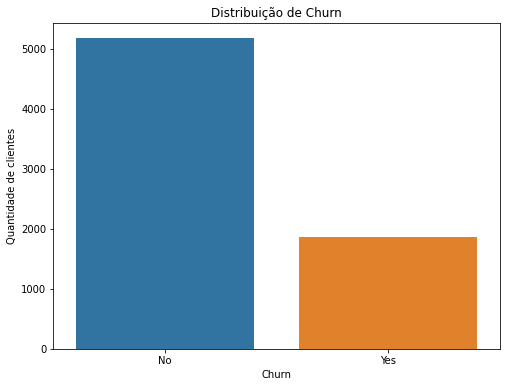

In [30]:
plt.figure(figsize=(8,6))
sns.countplot(dados['Churn'], order=dados['Churn'].value_counts().index[::1])
plt.title('Distribuição de Churn')
plt.xlabel('Churn')
plt.ylabel('Quantidade de clientes')
plt.show()

In [31]:
# Churn
print('0 não churn e 1 churn\n',(dados['Churn'].value_counts() / dados.shape[0] * 100).round(2))

0 não churn e 1 churn
 No    73.46
Yes   26.54
Name: Churn, dtype: float64


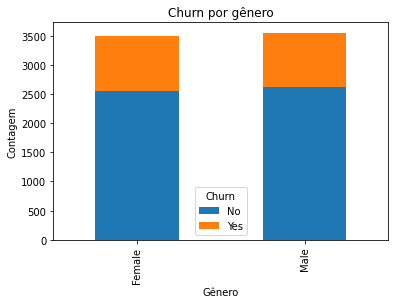

In [32]:
# gráfico de barras do churn por Gênero
gender_churn = dados.groupby(['Genero', 'Churn'])['Churn'].count().unstack()
gender_churn.plot(kind='bar', stacked=True)
plt.title('Churn por gênero')
plt.xlabel('Gênero')
plt.ylabel('Contagem')
plt.show()

In [33]:
frequencia_genero = dados['Genero'].value_counts()
percentual_genero = dados['Genero'].value_counts(normalize = True)*100
percentual_genero = pd.DataFrame({'Frequência': frequencia_genero, 'Porcentagem(%)': percentual_genero})
percentual_genero

,Frequência,Porcentagem(%)
Male,3555,50.48
Female,3488,49.52


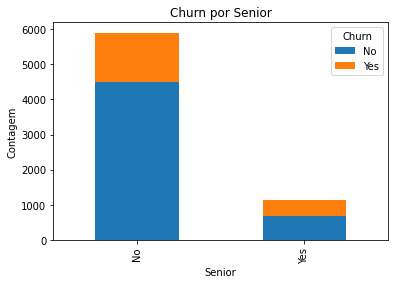

In [34]:
# gráfico de barras do churn por Senior
gender_churn = dados.groupby(['Senior', 'Churn'])['Churn'].count().unstack()
gender_churn.plot(kind='bar', stacked=True)
plt.title('Churn por Senior')
plt.xlabel('Senior')
plt.ylabel('Contagem')
plt.show()

In [35]:
frequencia_senior = dados['Senior'].value_counts()
percentual_senior = dados['Senior'].value_counts(normalize = True)*100
percentual_senior = pd.DataFrame({'Frequência': frequencia_senior, 'Porcentagem(%)': percentual_senior})
percentual_senior

,Frequência,Porcentagem(%)
No,5901,83.79
Yes,1142,16.21


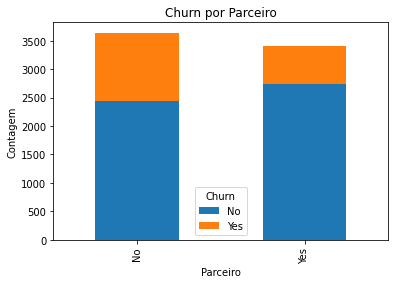

In [36]:
# gráfico de barras do churn por Parceiro
gender_churn = dados.groupby(['Parceiro', 'Churn'])['Churn'].count().unstack()
gender_churn.plot(kind='bar', stacked=True)
plt.title('Churn por Parceiro')
plt.xlabel('Parceiro')
plt.ylabel('Contagem')
plt.show()

In [37]:
frequencia_parceiro = dados['Parceiro'].value_counts()
percentual_parceiro = dados['Parceiro'].value_counts(normalize = True)*100
percentual_parceiro = pd.DataFrame({'Frequência': frequencia_parceiro, 'Porcentagem(%)': percentual_parceiro})
percentual_parceiro

,Frequência,Porcentagem(%)
No,3641,51.70
Yes,3402,48.30


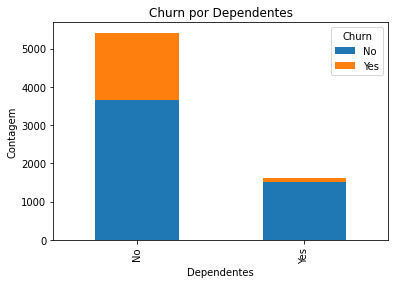

In [38]:
# gráfico de barras do churn por Dependentes
gender_churn = dados.groupby(['Dependentes', 'Churn'])['Churn'].count().unstack()
gender_churn.plot(kind='bar', stacked=True)
plt.title('Churn por Dependentes')
plt.xlabel('Dependentes')
plt.ylabel('Contagem')
plt.show()

In [39]:
frequencia_dependentes = dados['Dependentes'].value_counts()
percentual_dependentes = dados['Dependentes'].value_counts(normalize = True)*100
percentual_dependentes = pd.DataFrame({'Frequência': frequencia_dependentes, 'Porcentagem(%)': percentual_dependentes})
percentual_dependentes

,Frequência,Porcentagem(%)
No,5416,76.90
Yes,1627,23.10


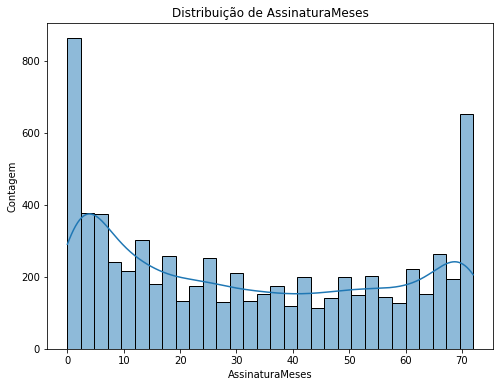

In [40]:
plt.figure(figsize=(8,6))
sns.histplot(dados['AssinaturaMeses'], bins=30, kde=True)
plt.title('Distribuição de AssinaturaMeses')
plt.xlabel('AssinaturaMeses')
plt.ylabel('Contagem')
plt.show()

<AxesSubplot:xlabel='StreamingFilmes', ylabel='count'>

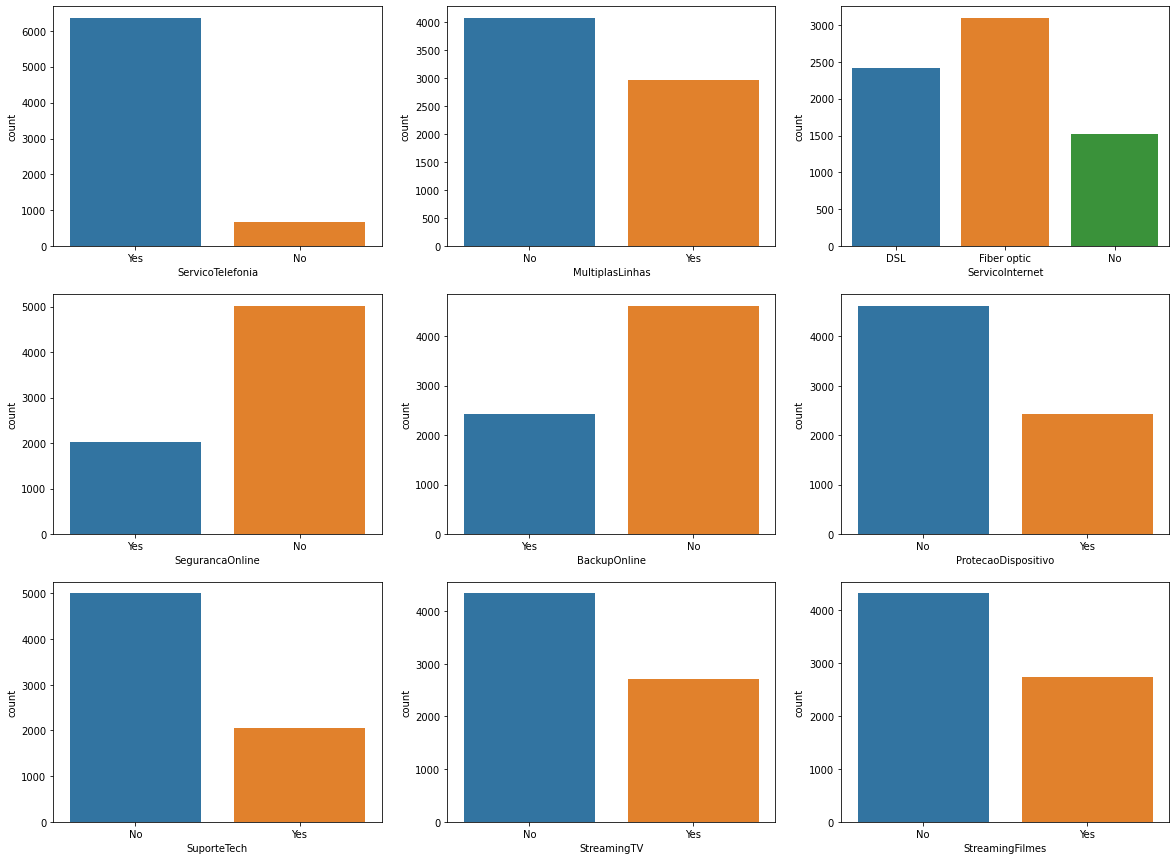

In [41]:
f, ax = plt.subplots(3,3, figsize=(20,15))
sns.countplot(dados['ServicoTelefonia'], ax=ax[0,0])
sns.countplot(dados['MultiplasLinhas'], ax=ax[0,1])
sns.countplot(dados['ServicoInternet'], ax=ax[0,2])
sns.countplot(dados['SegurancaOnline'], ax=ax[1,0])
sns.countplot(dados['BackupOnline'], ax=ax[1,1])
sns.countplot(dados['ProtecaoDispositivo'], ax=ax[1,2])
sns.countplot(dados['SuporteTech'], ax=ax[2,0])
sns.countplot(dados['StreamingTV'], ax=ax[2,1])
sns.countplot(dados['StreamingFilmes'], ax=ax[2,2])

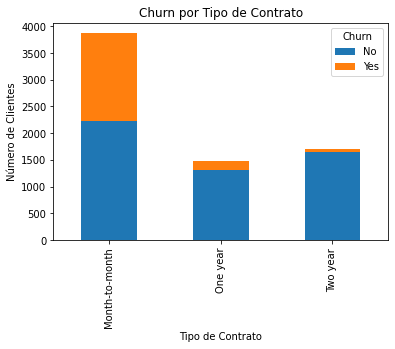

In [42]:
# Analisando o churn por categoria de Contrato
contract_churn = dados.groupby(['TipoContrato', 'Churn']).size().unstack()
contract_churn.plot(kind='bar', stacked=True)
plt.xlabel('Tipo de Contrato')
plt.ylabel('Número de Clientes')
plt.title('Churn por Tipo de Contrato')
plt.show()

In [43]:
frequencia_faturasempapel = dados['FaturaSemPapel'].value_counts()
percentual_faturasempapel = dados['FaturaSemPapel'].value_counts(normalize = True)*100
percentual_faturasempapel = pd.DataFrame({'Frequência': frequencia_faturasempapel, 'Porcentagem(%)': percentual_faturasempapel})
percentual_faturasempapel

,Frequência,Porcentagem(%)
Yes,4171,59.22
No,2872,40.78


Text(0.5, 1.0, 'Contrato de dois anos')

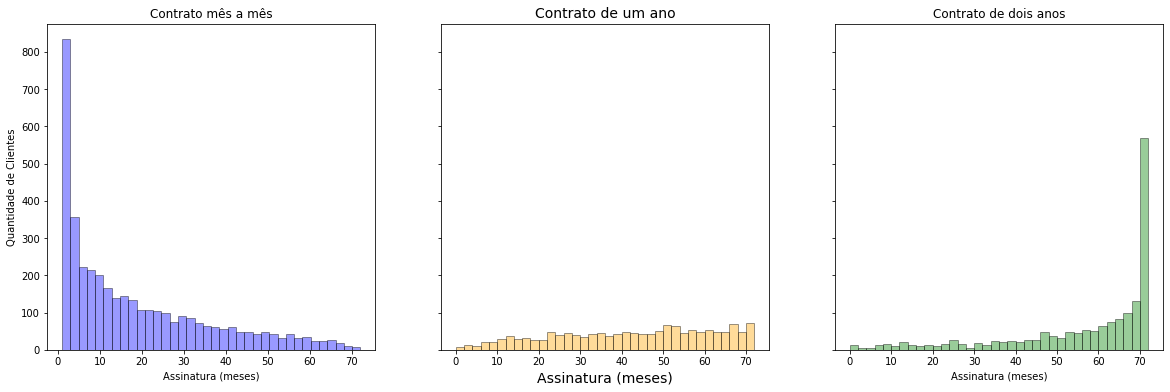

In [44]:
fig, (ax1,ax2,ax3) = plt.subplots(nrows=1, ncols=3, sharey = True, figsize = (20,6))

ax = sns.distplot(dados[dados['TipoContrato']=='Month-to-month']['AssinaturaMeses'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'blue',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax1)
ax.set_ylabel('Quantidade de Clientes')
ax.set_xlabel('Assinatura (meses)')
ax.set_title('Contrato mês a mês')

ax = sns.distplot(dados[dados['TipoContrato']=='One year']['AssinaturaMeses'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'orange',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax2)
ax.set_xlabel('Assinatura (meses)',size = 14)
ax.set_title('Contrato de um ano',size = 14)

ax = sns.distplot(dados[dados['TipoContrato']=='Two year']['AssinaturaMeses'],
                   hist=True, kde=False,
                   bins=int(180/5), color = 'green',
                   hist_kws={'edgecolor':'black'},
                   kde_kws={'linewidth': 4},
                 ax=ax3)

ax.set_xlabel('Assinatura (meses)')
ax.set_title('Contrato de dois anos')

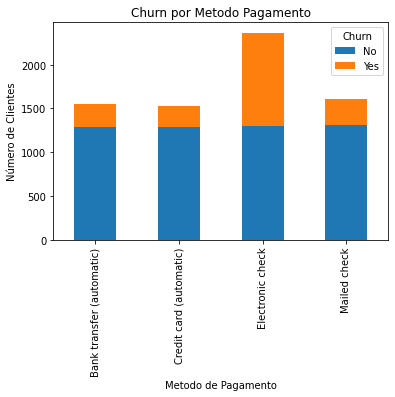

In [45]:
# Analisando o churn por Metodo de Pagamento
contract_churn = dados.groupby(['MetodoPagamento', 'Churn']).size().unstack()
contract_churn.plot(kind='bar', stacked=True)
plt.xlabel('Metodo de Pagamento')
plt.ylabel('Número de Clientes')
plt.title('Churn por Metodo Pagamento')
plt.show()

In [46]:
frequencia_metodopagamento = dados['MetodoPagamento'].value_counts()
percentual_metodopagamento = dados['MetodoPagamento'].value_counts(normalize = True)*100
percentual_metodopagamento = pd.DataFrame({'Frequência': frequencia_metodopagamento, 'Porcentagem(%)': percentual_metodopagamento})
percentual_metodopagamento

,Frequência,Porcentagem(%)
Electronic check,2365,33.58
Mailed check,1612,22.89
Bank transfer (automatic),1544,21.92
Credit card (automatic),1522,21.61


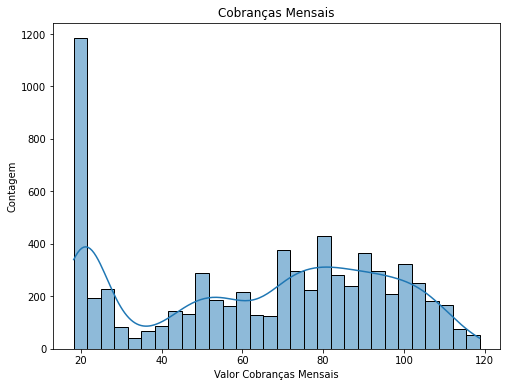

In [47]:
plt.figure(figsize=(8,6))
sns.histplot(dados['CobrancasMensais'], bins=30, kde=True)
plt.title('Cobranças Mensais')
plt.xlabel('Valor Cobranças Mensais')
plt.ylabel('Contagem')
plt.show()

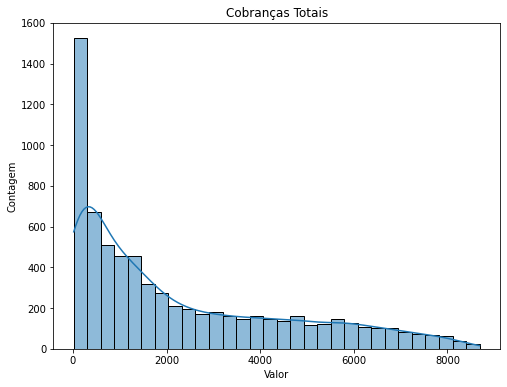

In [48]:
plt.figure(figsize=(8,6))
sns.histplot(dados['CobrancasTotais'], bins=30, kde=True)
plt.title('Cobranças Totais')
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.show()

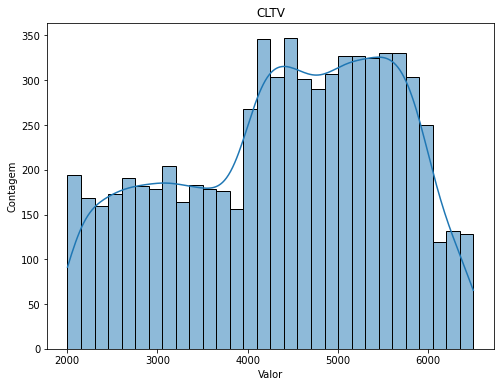

In [49]:
plt.figure(figsize=(8,6))
sns.histplot(dados['CLTV'], bins=30, kde=True)
plt.title('CLTV')
plt.xlabel('Valor')
plt.ylabel('Contagem')
plt.show()

In [50]:
# criar a matriz de correlação
corr_matrix = dados.corr()

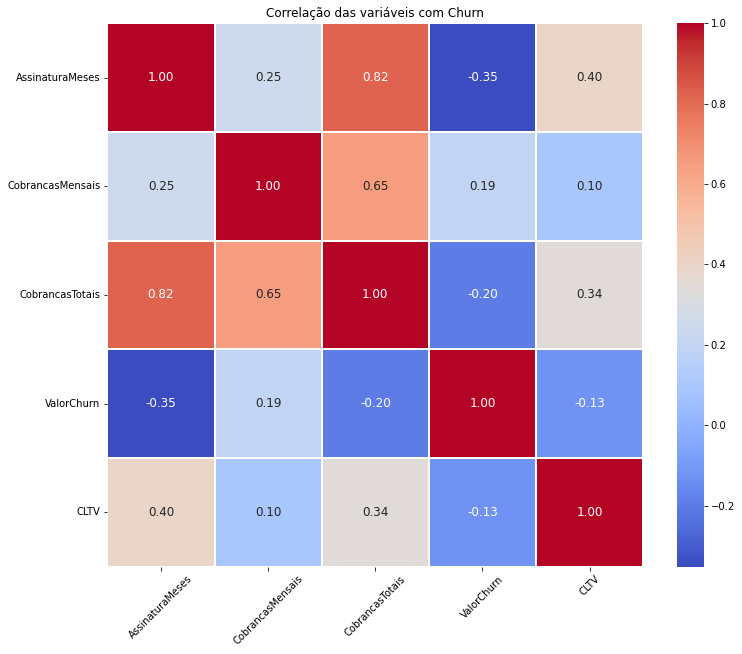

In [51]:
# criar o heatmap
plt.figure(figsize=(12,10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm',
            fmt='.2f', linewidths=.05, annot_kws={"size": 12})
plt.title('Correlação das variáveis com Churn')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [52]:
dados.select_dtypes(include='int64').describe().round(2)

,AssinaturaMeses,ValorChurn,CLTV
count,7043.00,7043.00,7043.00
mean,32.37,0.27,4400.30
std,24.56,0.44,1183.06
min,0.00,0.00,2003.00
25%,9.00,0.00,3469.00
50%,29.00,0.00,4527.00
75%,55.00,1.00,5380.50
max,72.00,1.00,6500.00


In [53]:
dados.select_dtypes(include='float64').describe().round(2)

,CobrancasMensais,CobrancasTotais
count,7043.00,7043.00
mean,64.76,2283.30
std,30.09,2265.00
min,18.25,18.80
25%,35.50,402.22
50%,70.35,1400.55
75%,89.85,3786.60
max,118.75,8684.80


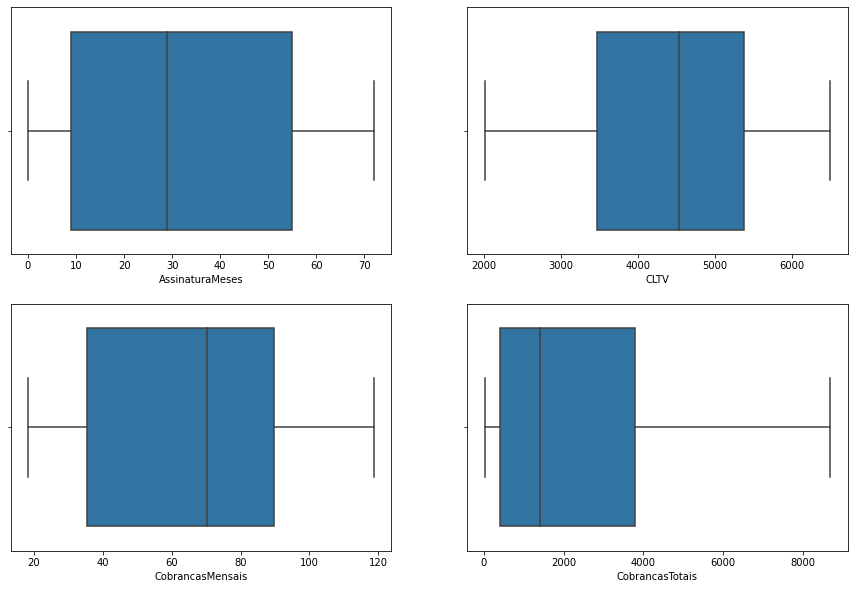

In [54]:
# Criar uma matriz de subplots 2x2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))


# Plotar cada gráfico em um subplot diferente
sns.boxplot(dados['AssinaturaMeses'], ax=axes[0,0])
sns.boxplot(dados['CLTV'], ax=axes[0,1])
sns.boxplot(dados['CobrancasMensais'], ax=axes[1,0])
sns.boxplot(dados['CobrancasTotais'], ax=axes[1,1])

# Exibir a figura
plt.show()

Não existem outliers dentro das variáveis numéricas

<AxesSubplot:xlabel='Churn', ylabel='CobrancasMensais'>

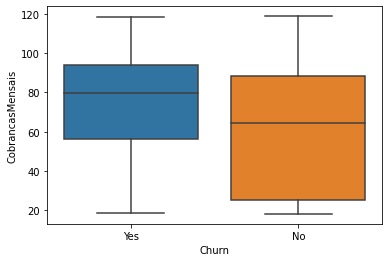

In [55]:
# Comparativo na variável CobrancasMensais, separadamente entre Churn: Sim e Não
sns.boxplot('Churn', 'CobrancasMensais', data=dados)

In [56]:
# Agrupando os dados por Churn para calcular estatísticas descritivas para cada grupo
stats = dados.groupby('Churn')['CobrancasMensais'].describe()

# Imprimir tabela com as estatísticas
print(stats)

        count  mean   std   min   25%   50%   75%    max
Churn                                                   
No    5174.00 61.27 31.09 18.25 25.10 64.43 88.40 118.75
Yes   1869.00 74.44 24.67 18.85 56.15 79.65 94.20 118.35


O valor mediano é superior nos clientes em Churn em relação aos Não Churn

In [57]:
# Criando uma nova variável para 'AssinaturaMeses' agrupando em classes, para melhor entendimento
# 0 a 12 meses
# 13 a 24 meses
# 24 a 48 meses
# 48 a 60 meses
# 60 + meses
classes = [0, 12, 24, 48, 60, 100]

tenure = pd.cut(dados['AssinaturaMeses'], classes)

pd.value_counts(tenure)

(0, 12]      2175
(24, 48]     1594
(60, 100]    1407
(12, 24]     1024
(48, 60]      832
Name: AssinaturaMeses, dtype: int64

In [58]:
labels = ['0 a 12 meses', '13 a 24 meses', '24 a 48 meses', '48 a 60 meses', '60 meses +']

In [59]:
tenure = pd.cut(dados['AssinaturaMeses'], classes, labels=labels)
pd.value_counts(tenure)

0 a 12 meses     2175
24 a 48 meses    1594
60 meses +       1407
13 a 24 meses    1024
48 a 60 meses     832
Name: AssinaturaMeses, dtype: int64

In [60]:
tenure = pd.cut(dados['AssinaturaMeses'], classes, labels=labels, include_lowest=True)
pd.value_counts(tenure)

0 a 12 meses     2186
24 a 48 meses    1594
60 meses +       1407
13 a 24 meses    1024
48 a 60 meses     832
Name: AssinaturaMeses, dtype: int64

<AxesSubplot:>

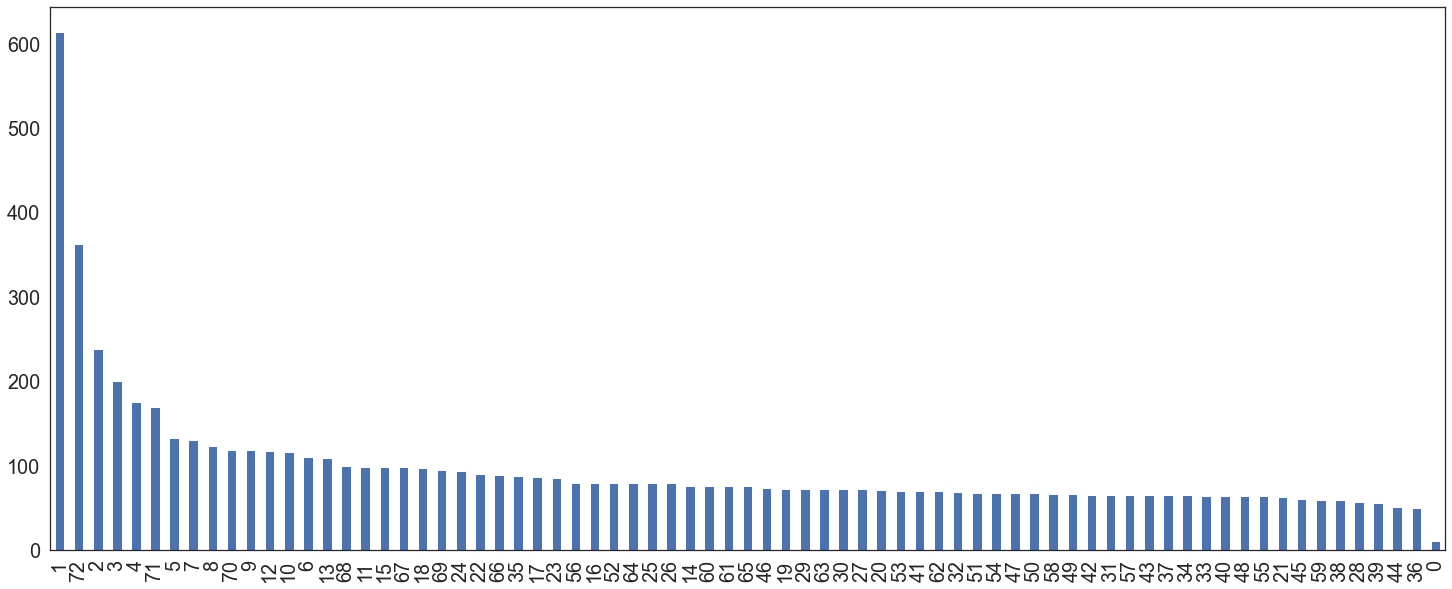

In [61]:
# Faixas temporais de permanência no serviço
# Configurar o tamanho da figura e a fonte dos rótulos
plt.figure(figsize=(25, 10))
sns.set(font_scale=1.8)
sns.set_style("whitegrid")  # ou sns.set_style("white")
sns.set_style("white")
dados['AssinaturaMeses'].value_counts().plot(kind='bar')

<AxesSubplot:>

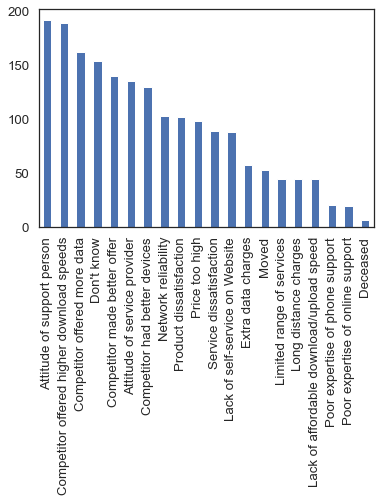

In [62]:
# Justificativas dos clientes para sair do serviço
sns.set(font_scale=1.2)
sns.set_style("whitegrid")  # ou sns.set_style("white")
sns.set_style("white")
dados['MotivoChurn'].value_counts().plot(kind='bar')

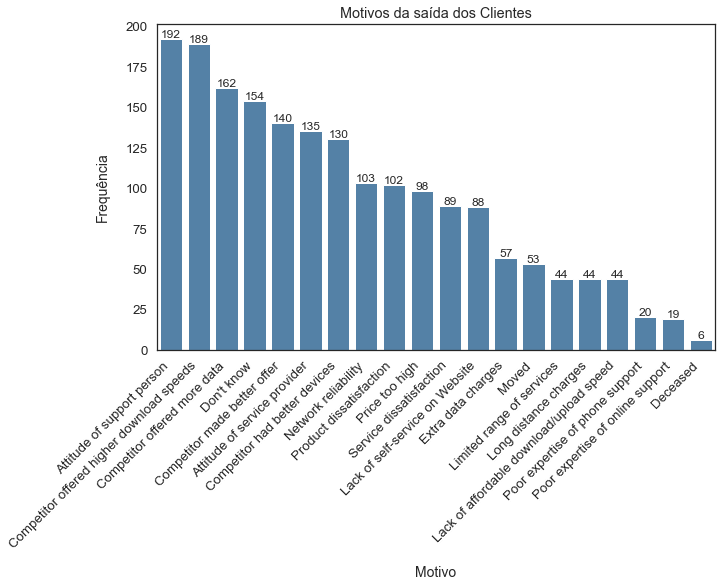

In [63]:
# Configurar o tamanho da figura e a fonte dos rótulos
plt.figure(figsize=(10, 6))
sns.set(font_scale=1.2)
sns.set_style("whitegrid")  # ou sns.set_style("white")
sns.set_style("white")

# Contar a frequência de cada motivo e ordenar as barras por frequência decrescente
motivos = dados['MotivoChurn'].value_counts().sort_values(ascending=False)

# Plotar o gráfico de barras
sns.barplot(x=motivos.index, y=motivos.values, color='steelblue')

# Adicionar rótulos aos eixos x e y
plt.title('Motivos da saída dos Clientes')
plt.xlabel('Motivo', labelpad=15, fontsize=14)
plt.ylabel('Frequência', labelpad=15, fontsize=14)

# Ajustar os rótulos do eixo x para evitar sobreposição
plt.xticks(rotation=45, ha='right')

# Ajustar o tamanho da fonte dos valores das barras
for index, value in enumerate(motivos.values):
    plt.text(index, value+1, str(value), ha='center', fontsize=12)

# Exibir a figura
plt.show()

In [64]:
motivo_churn = (dados['MotivoChurn'].value_counts() / dados['MotivoChurn'].value_counts().sum() * 100).round(2)
motivo_churn

Attitude of support person                  10.27
Competitor offered higher download speeds   10.11
Competitor offered more data                 8.67
Don't know                                   8.24
Competitor made better offer                 7.49
Attitude of service provider                 7.22
Competitor had better devices                6.96
Network reliability                          5.51
Product dissatisfaction                      5.46
Price too high                               5.24
Service dissatisfaction                      4.76
Lack of self-service on Website              4.71
Extra data charges                           3.05
Moved                                        2.84
Limited range of services                    2.35
Long distance charges                        2.35
Lack of affordable download/upload speed     2.35
Poor expertise of phone support              1.07
Poor expertise of online support             1.02
Deceased                                     0.32


In [65]:
print('Justificativa \n',dados['MotivoChurn'].value_counts() / dados.shape[0] * 100)

Justificativa 
 Attitude of support person                  2.73
Competitor offered higher download speeds   2.68
Competitor offered more data                2.30
Don't know                                  2.19
Competitor made better offer                1.99
Attitude of service provider                1.92
Competitor had better devices               1.85
Network reliability                         1.46
Product dissatisfaction                     1.45
Price too high                              1.39
Service dissatisfaction                     1.26
Lack of self-service on Website             1.25
Extra data charges                          0.81
Moved                                       0.75
Limited range of services                   0.62
Long distance charges                       0.62
Lack of affordable download/upload speed    0.62
Poor expertise of phone support             0.28
Poor expertise of online support            0.27
Deceased                                    0.09
Name

# 4. Preparação dos dados para modelos de machine learning

In [66]:
dados.drop(['Churn'], inplace=True, axis=1)

As variáveis categóricas devem ser transformadas em variáveis "dummies" para a aplicação no modelo de machine learning

In [67]:
dados_dummies = pd.get_dummies(dados, columns=['Cidade'], prefix='Cidade')
dados_dummies = pd.get_dummies(dados_dummies, columns=['Genero'], prefix='Genero')
dados_dummies = pd.get_dummies(dados_dummies, columns=['Senior'], prefix='Senior')
dados_dummies = pd.get_dummies(dados_dummies, columns=['Parceiro'], prefix='Parceiro')
dados_dummies = pd.get_dummies(dados_dummies, columns=['Dependentes'], prefix='Dependentes')
dados_dummies = pd.get_dummies(dados_dummies, columns=['ServicoTelefonia'], prefix='ServicoTelefonia')
dados_dummies = pd.get_dummies(dados_dummies, columns=['MultiplasLinhas'], prefix='MultiplasLinhas')
dados_dummies = pd.get_dummies(dados_dummies, columns=['ServicoInternet'], prefix='ServicoInternet')
dados_dummies = pd.get_dummies(dados_dummies, columns=['SegurancaOnline'], prefix='SegurancaOnline')
dados_dummies = pd.get_dummies(dados_dummies, columns=['BackupOnline'], prefix='BackupOnline')
dados_dummies = pd.get_dummies(dados_dummies, columns=['ProtecaoDispositivo'], prefix='ProtecaoDispositivo')
dados_dummies = pd.get_dummies(dados_dummies, columns=['SuporteTech'], prefix='SuporteTech')
dados_dummies = pd.get_dummies(dados_dummies, columns=['StreamingTV'], prefix='StreamingTV')
dados_dummies = pd.get_dummies(dados_dummies, columns=['StreamingFilmes'], prefix='StreamingFilmes')
dados_dummies = pd.get_dummies(dados_dummies, columns=['TipoContrato'], prefix='TipoContrato')
dados_dummies = pd.get_dummies(dados_dummies, columns=['FaturaSemPapel'], prefix='FaturaSemPapel')
dados_dummies = pd.get_dummies(dados_dummies, columns=['MetodoPagamento'], prefix='MetodoPagamento')
dados_dummies = pd.get_dummies(dados_dummies, columns=['MotivoChurn'], prefix='MotivoChurn')


dados_dummies.head()

,AssinaturaMeses,CobrancasMensais,CobrancasTotais,ValorChurn,CLTV,Cidade_Acampo,Cidade_Acton,Cidade_Adelanto,Cidade_Adin,Cidade_Agoura Hills,...,MotivoChurn_Lack of self-service on Website,MotivoChurn_Limited range of services,MotivoChurn_Long distance charges,MotivoChurn_Moved,MotivoChurn_Network reliability,MotivoChurn_Poor expertise of online support,MotivoChurn_Poor expertise of phone support,MotivoChurn_Price too high,MotivoChurn_Product dissatisfaction,MotivoChurn_Service dissatisfaction
0,2,53.85,108.15,1,3239,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,70.70,151.65,1,2701,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,8,99.65,820.50,1,5372,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,28,104.80,3046.05,1,5003,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,49,103.70,5036.30,1,5340,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [68]:
# Ajustando o nome de cada variável, removendo espaços e adicionando 'underscore' no lugar
dados_dummies.columns = [i.replace(' ', '_') for i in dados_dummies.columns]
dados_dummies

,AssinaturaMeses,CobrancasMensais,CobrancasTotais,ValorChurn,CLTV,Cidade_Acampo,Cidade_Acton,Cidade_Adelanto,Cidade_Adin,Cidade_Agoura_Hills,...,MotivoChurn_Lack_of_self-service_on_Website,MotivoChurn_Limited_range_of_services,MotivoChurn_Long_distance_charges,MotivoChurn_Moved,MotivoChurn_Network_reliability,MotivoChurn_Poor_expertise_of_online_support,MotivoChurn_Poor_expertise_of_phone_support,MotivoChurn_Price_too_high,MotivoChurn_Product_dissatisfaction,MotivoChurn_Service_dissatisfaction
0,2,53.85,108.15,1,3239,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,70.70,151.65,1,2701,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,8,99.65,820.50,1,5372,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,28,104.80,3046.05,1,5003,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,49,103.70,5036.30,1,5340,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,72,21.15,1419.40,0,5306,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7039,24,84.80,1990.50,0,2140,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
7040,72,103.20,7362.90,0,5560,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7041,11,29.60,346.45,0,2793,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# 5. Divisão dos dados em treino e teste

In [69]:
X = dados_dummies.drop('ValorChurn', axis=1)
y = dados_dummies['ValorChurn']

In [70]:
labels = y

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.2, random_state=1)

# 6. Treinamento dos dados nos modelos de Machine Learning

## Árvore de Decisão

In [72]:
arvore_de_decisao = DecisionTreeClassifier(max_depth=7,
                                 max_features=None,
                                 criterion='entropy',
                                 min_samples_leaf=1,
                                 min_samples_split=2,
                                 random_state=1)

In [73]:
arvore_de_decisao.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=7, random_state=1)

In [74]:
import eli5
from eli5 import show_prediction
eli5.show_weights(arvore_de_decisao, feature_names = list(X)[0:1190])

Weight,Feature
0.3462,TipoContrato_Month-to-month
0.1236,MotivoChurn_Competitor_offered_higher_download_speeds
0.1036,MotivoChurn_Competitor_offered_more_data
0.0962,MotivoChurn_Attitude_of_support_person
0.0823,MotivoChurn_Don't_know
0.0769,MotivoChurn_Competitor_had_better_devices
0.0754,MotivoChurn_Competitor_made_better_offer
0.0370,Dependentes_Yes
0.0272,ServicoInternet_Fiber_optic
0.0131,MotivoChurn_Attitude_of_service_provider


In [75]:
importances = arvore_de_decisao.feature_importances_
feature_names = X.columns

# Criar um dataframe com as informações
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importancia': importances})

# Ordenar o dataframe pela coluna 'importance'
feature_importances = feature_importances.sort_values(by='Importancia', ascending=False)

# Exibir o dataframe ordenado
print(feature_importances)
feature_importances.head(10)

                                                Feature  Importancia
1160                        TipoContrato_Month-to-month         0.35
1173  MotivoChurn_Competitor_offered_higher_download...         0.12
1174           MotivoChurn_Competitor_offered_more_data         0.10
1170             MotivoChurn_Attitude_of_support_person         0.10
1176                             MotivoChurn_Don't_know         0.08
...                                                 ...          ...
396                                      Cidade_Gridley         0.00
395                                      Cidade_Grenada         0.00
394                                    Cidade_Greenwood         0.00
393                                   Cidade_Greenville         0.00
1188                MotivoChurn_Service_dissatisfaction         0.00

[1189 rows x 2 columns]


,Feature,Importancia
1160,TipoContrato_Month-to-month,0.35
1173,MotivoChurn_Competitor_offered_higher_download...,0.12
1174,MotivoChurn_Competitor_offered_more_data,0.10
1170,MotivoChurn_Attitude_of_support_person,0.10
1176,MotivoChurn_Don't_know,0.08
1171,MotivoChurn_Competitor_had_better_devices,0.08
1172,MotivoChurn_Competitor_made_better_offer,0.08
1140,Dependentes_Yes,0.04
1146,ServicoInternet_Fiber_optic,0.03
1169,MotivoChurn_Attitude_of_service_provider,0.01


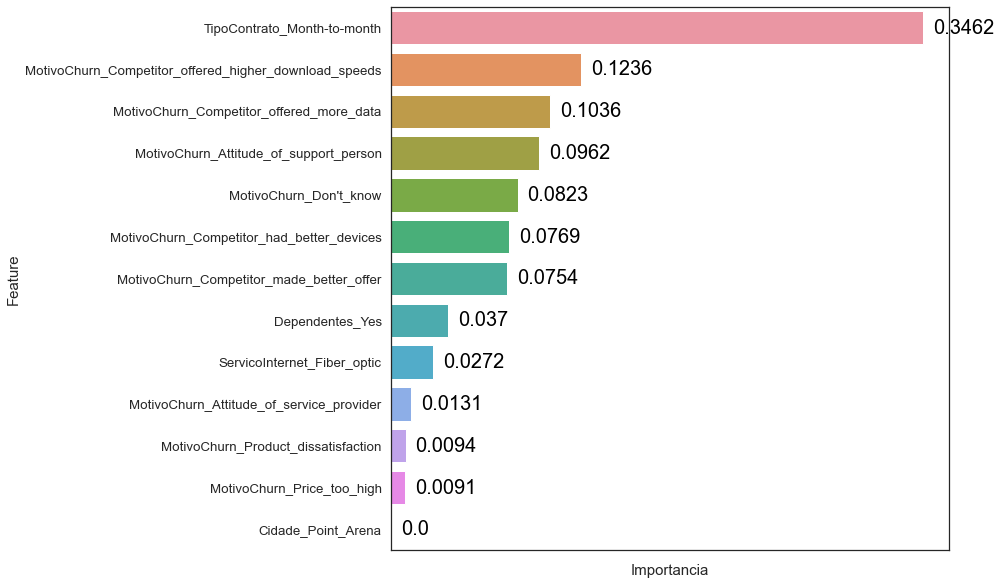

In [76]:
plt.figure(figsize=(10, 10))
plt.rcParams.update({'font.size': 15})
features_plot = sns.barplot(data=feature_importances.iloc[:13,:], x='Importancia', y='Feature')
for i in features_plot.patches:
    features_plot.annotate(round(i.get_width(), 4),
                            xy=(i.get_width(), i.get_y() + i.get_height() / 2),
                            xytext=(10, 0),
                            textcoords='offset points',
                            ha='left', va='center', fontsize=20,
                            color='black')
features_plot.set_xticklabels(features_plot.get_xticklabels(), rotation=0, ha="center")
plt.xlabel('Importancia', fontsize=15)
plt.ylabel('Feature', fontsize=15)
sns.set_style("white")
plt.show()

In [77]:
dot_data = export_graphviz(arvore_de_decisao, out_file=None,
                           class_names=["não churn", "churn"],
                           feature_names= X.columns.tolist(),
                           impurity=False, 
                           filled=True, rounded=True,
                           special_characters=True)

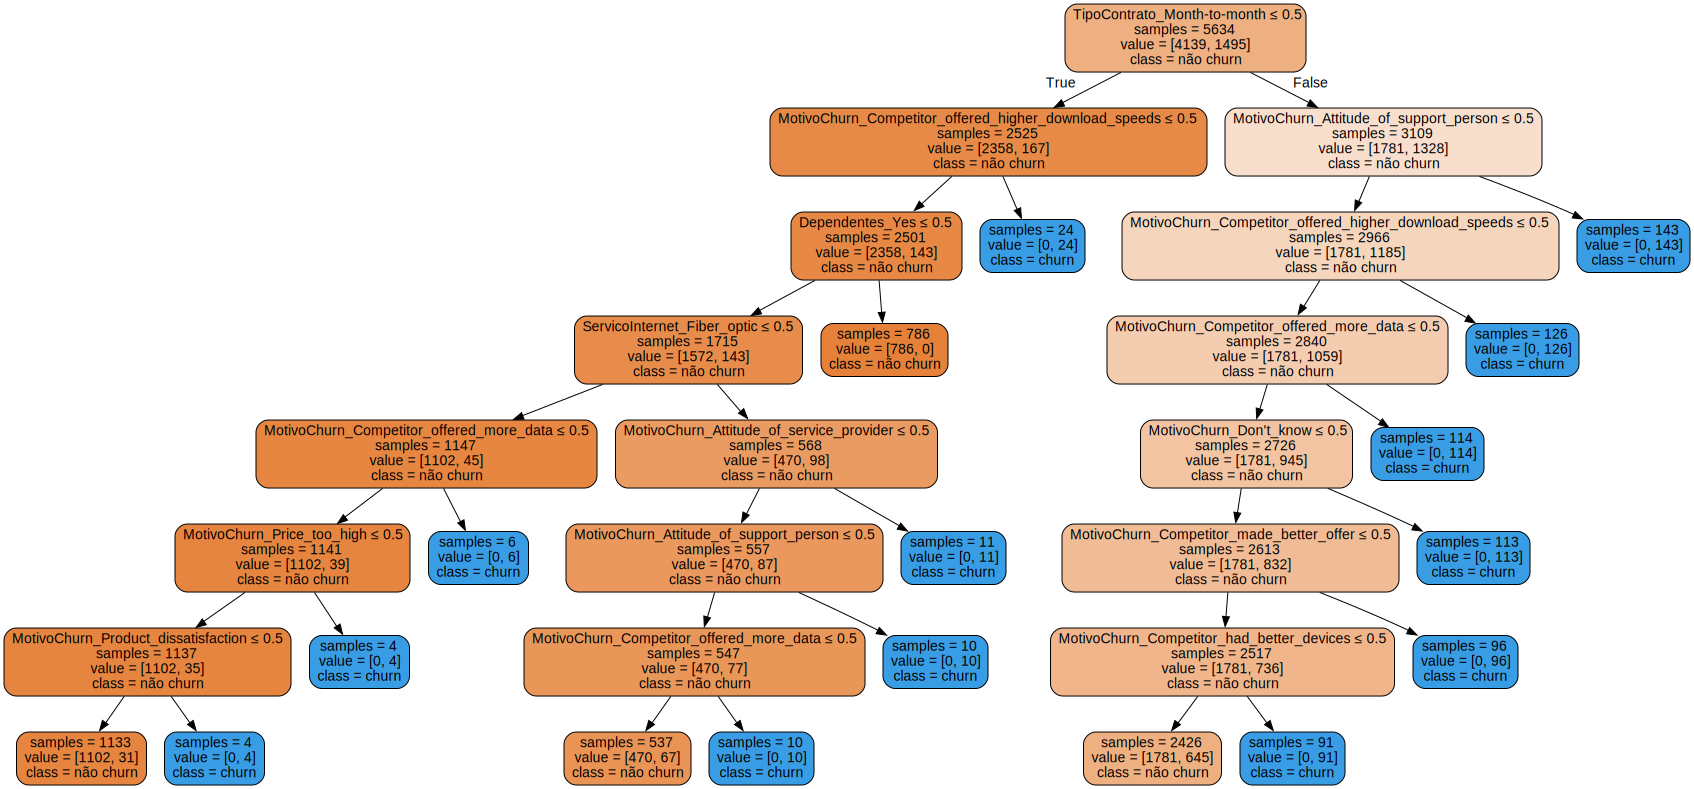

In [78]:
graphviz.Source(dot_data)

In [79]:
export_graphviz(arvore_de_decisao, out_file="arvore_de_decisao.dot", class_names=["nao churn", "churn"],
               impurity=False, filled=True)

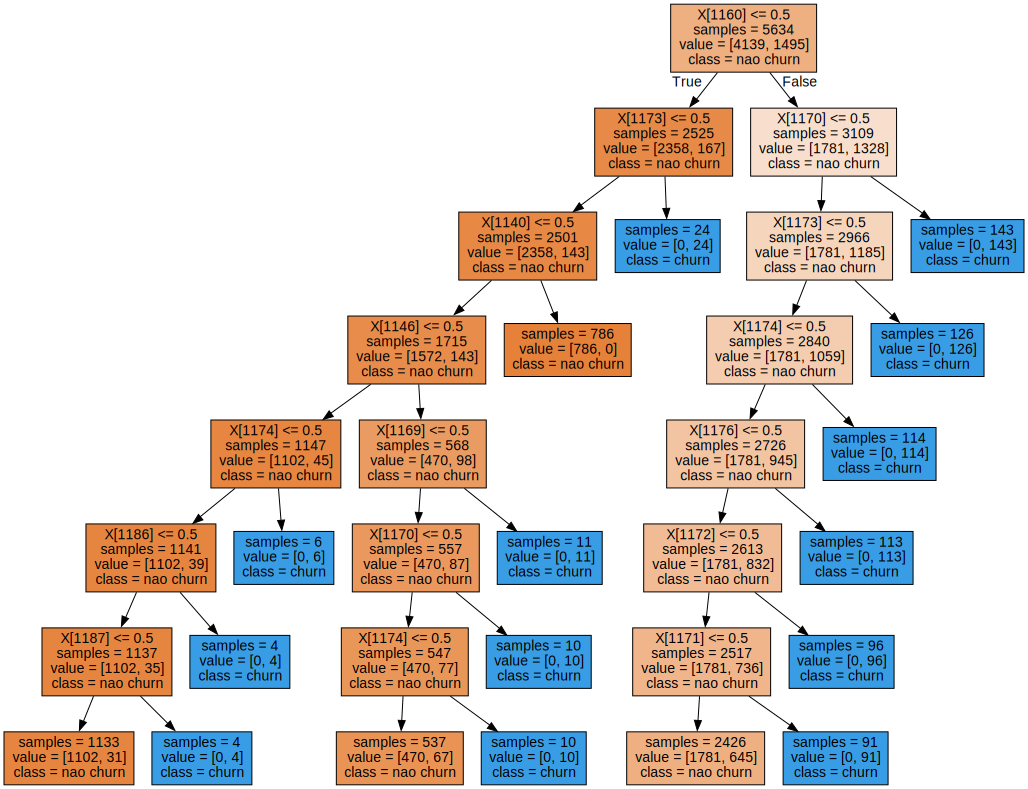

In [80]:
import graphviz
with open("arvore_de_decisao.dot") as f:
    dot_graph = f.read()
graphviz.Source(dot_graph)

## Random Forest

In [81]:
rf = RandomForestClassifier(n_estimators=5, random_state=2)
y_pred_rf = rf.fit(X_train, y_train)

# XGBoost

In [82]:
xgb = XGBClassifier(random_state=2)
y_pred_xgb = xgb.fit(X_train, y_train)

## Regressão Logística

In [83]:
rl = LogisticRegression(random_state=2)
y_pred_rl = rl.fit(X_train, y_train)

# 7. Avaliação de performance dos modelos

### Árvore de Decisão - Acurácia

In [84]:
#Árvore de Decisão - Sem ajuste
print("Acurácia no treinamento: {:.2f}%".format(arvore_de_decisao.score(X_train, y_train)*100))
print("Acurácia no teste: {:.2f}%".format(arvore_de_decisao.score(X_test, y_test)*100))

Acurácia no treinamento: 86.81%
Acurácia no teste: 87.30%


### Árvore de Decisão -  AUC ROC

In [85]:
# Calcular a probabilidade de classificação no conjunto de teste
probabilidades_arvore_de_decisao = arvore_de_decisao.predict_proba(X_test)[:, 1]

In [86]:
# Calcular a curva ROC e a área sob a curva (AUC)
fpr_arvore_de_decisao, tpr_arvore_de_decisao, limiares_arvore_de_decisao = roc_curve(y_test, probabilidades_arvore_de_decisao)
roc_auc_arvore_de_decisao = auc(fpr_arvore_de_decisao, tpr_arvore_de_decisao)

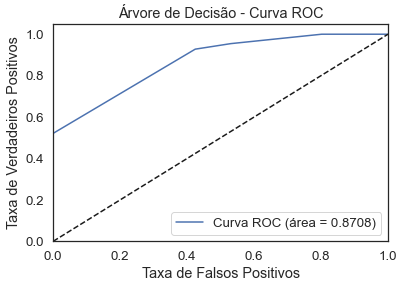

In [87]:
plt.plot(fpr_arvore_de_decisao, tpr_arvore_de_decisao, label='Curva ROC (área = %0.4f)' % roc_auc_arvore_de_decisao)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Árvore de Decisão - Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Random Forest - Acurácia

In [92]:
#Random Forest
print("Acurácia no treinamento: {:.2f}%".format(rf.score(X_train, y_train)*100))
print("Acurácia no teste: {:.2f}%".format(rf.score(X_test, y_test)*100))

Acurácia no treinamento: 98.70%
Acurácia no teste: 85.45%


### Random Forest - AUC ROC

In [88]:
# Calcular a probabilidade de classificação no conjunto de teste
probabilidades_rf = rf.predict_proba(X_test)[:, 1]

In [89]:
# Calcular a curva ROC e a área sob a curva (AUC)
fpr_rf, tpr_rf, limiares_rf = roc_curve(y_test, probabilidades_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)

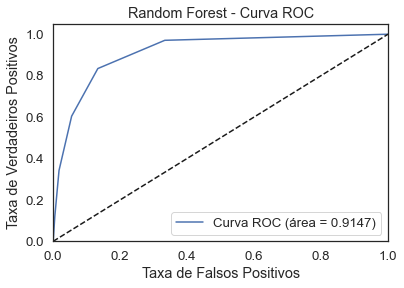

In [90]:
plt.plot(fpr_rf, tpr_rf, label='Curva ROC (área = %0.4f)' % roc_auc_rf)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Random Forest - Curva ROC')
plt.legend(loc="lower right")
plt.show()

### XGBoost - Acurácia

In [91]:
#XGBoost
print("Acurácia no treinamento: {:.2f}%".format(xgb.score(X_train, y_train)*100))
print("Acurácia no teste: {:.2f}%".format(xgb.score(X_test, y_test)*100))

Acurácia no treinamento: 99.98%
Acurácia no teste: 99.93%


### XGBoost - AUC ROC

In [92]:
# Calcular a probabilidade de classificação no conjunto de teste
probabilidades_xgb = xgb.predict_proba(X_test)[:, 1]

In [93]:
# Calcular a curva ROC e a área sob a curva (AUC)
fpr_xgb, tpr_xgb, limiares_xgb = roc_curve(y_test, probabilidades_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

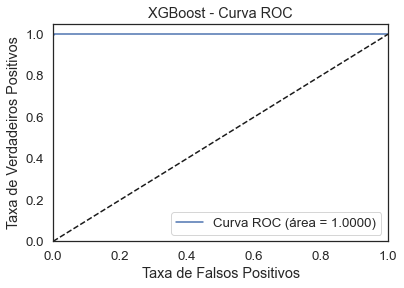

In [94]:
plt.plot(fpr_xgb, tpr_xgb, label='Curva ROC (área = %0.4f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('XGBoost - Curva ROC')
plt.legend(loc="lower right")
plt.show()

### Regressão Logística - Acurácia

In [95]:
#Regressão Logística
print("Acurácia no treinamento: {:.2f}%".format(rl.score(X_train, y_train)*100))
print("Acurácia no teste: {:.2f}%".format(rl.score(X_test, y_test)*100))

Acurácia no treinamento: 87.29%
Acurácia no teste: 87.37%


### Regressão Logística - AUC ROC

In [96]:
# Calcular a probabilidade de classificação no conjunto de teste
probabilidades_rl = rl.predict_proba(X_test)[:, 1]

In [97]:
# Calcular a curva ROC e a área sob a curva (AUC)
fpr_rl, tpr_rl, limiares_rl = roc_curve(y_test, probabilidades_rl)
roc_auc_rl = auc(fpr_rl, tpr_rl)

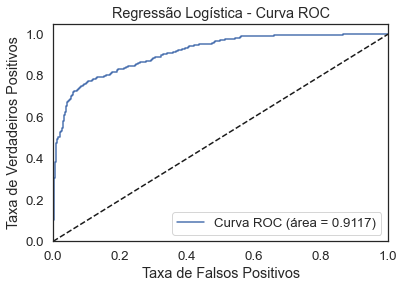

In [98]:
plt.plot(fpr_rl, tpr_rl, label='Curva ROC (área = %0.4f)' % roc_auc_rl)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Regressão Logística - Curva ROC')
plt.legend(loc="lower right")
plt.show()